In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, DenseNet201, EfficientNetB0
import tensorflow_hub as hub  # For Vision Transformer (ViT)
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Constants
IMAGE_SIZE = 224  # Standard size for most models
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
n_classes = 27  # Adjust according to your dataset (e.g., 27 for potato leaf diseases)
DATASET_DIR = "C:\\Users\\91630\\OneDrive\\Desktop\\Sem 7\\Mobile Application\\Lab Eval\\Dataset-MAD"

In [3]:
# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 2152 files belonging to 2 classes.


In [7]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize dataset for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Model function to create various pretrained models
def create_model(model_name):
    if model_name == "VGG16":
        base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
    elif model_name == "DenseNet201":
        base_model = DenseNet201(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
    elif model_name == "EfficientNet":
        base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
    elif model_name == "ViT":
        # Load Vision Transformer from TensorFlow Hub
        base_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), trainable=False)

    if model_name != "ViT":
        base_model.trainable = False  # Freeze base model layers
    
    # Add custom layers on top of the base model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D() if model_name != "ViT" else layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In [9]:
# Compile, train, and evaluate a model
def compile_and_train(model, model_name):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
    
    # Evaluate model
    loss, accuracy = model.evaluate(test_ds)
    print(f"{model_name} Test Accuracy: {accuracy}")
    
    return history, accuracy, loss

In [10]:
# Compute F1 score and confusion matrix
def evaluate_model(model, model_name):
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    # Compute F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} F1 Score: {f1}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return f1, cm


In [15]:
models_to_train = ["VGG16", "DenseNet201", "EfficientNet", "ViT"]
results = {}

Training VGG16...
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.5876 - loss: 3.5446 - val_accuracy: 0.7396 - val_loss: 0.8725
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 333s 6s/step - accuracy: 0.7062 - loss: 1.0680 - val_accuracy: 0.7604 - val_loss: 1.5934
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.7279 - loss: 0.9877 - val_accuracy: 0.7292 - val_loss: 0.6187
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.7028 - loss: 0.8463 - val_accuracy: 0.7500 - val_loss: 0.5889
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 406s 8s/step - accuracy: 0.7357 - loss: 0.7526 - val_accuracy: 0.7656 - val_loss: 0.5678
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.7565 - loss: 0.6731 - val_accuracy: 0.7656 - val_loss: 0.5964
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.7619 - loss: 0.6513 - val_accuracy: 0.7604 - val_loss: 0.5308
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.7414 - loss: 0.6291 - val_ac

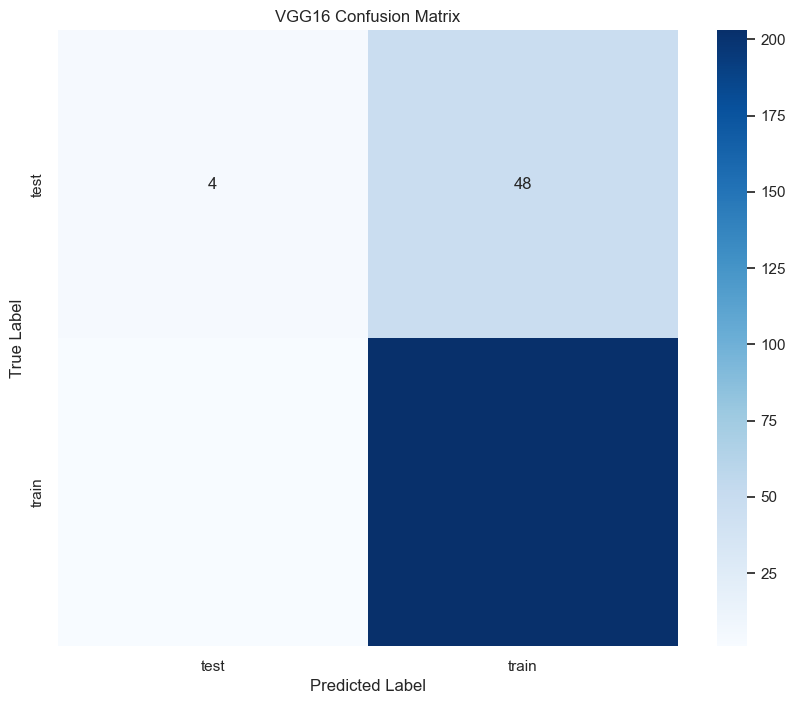

Training DenseNet201...
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.6782 - loss: 1.5451 - val_accuracy: 0.7604 - val_loss: 0.6412
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7328 - loss: 0.6835 - val_accuracy: 0.7552 - val_loss: 0.5394
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7358 - loss: 0.6157 - val_accuracy: 0.5938 - val_loss: 0.6606
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7635 - loss: 0.5742 - val_accuracy: 0.7656 - val_loss: 0.5300
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7605 - loss: 0.5638 - val_accuracy: 0.7552 - val_loss: 0.5315
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7983 - loss: 0.5053 - val_accuracy: 0.7604 - val_loss: 0.5247
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8007 - loss: 0.5139 - val_accuracy: 0.7604 - val_loss: 0.5259
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8084 - loss: 0.4856 - 

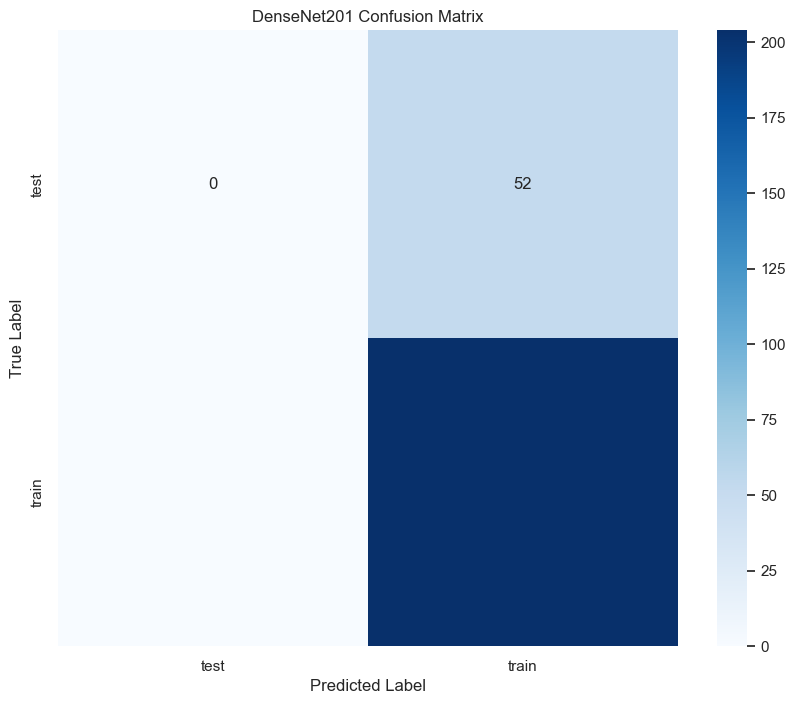

Training EfficientNet...
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 977ms/step - accuracy: 0.6910 - loss: 1.0968 - val_accuracy: 0.7604 - val_loss: 0.5497
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 795ms/step - accuracy: 0.7825 - loss: 0.5263 - val_accuracy: 0.7604 - val_loss: 0.5932
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 744ms/step - accuracy: 0.7733 - loss: 0.5371 - val_accuracy: 0.7604 - val_loss: 0.5535
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 749ms/step - accuracy: 0.8063 - loss: 0.4888 - val_accuracy: 0.7604 - val_loss: 0.5525
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 761ms/step - accuracy: 0.8016 - loss: 0.5043 - val_accuracy: 0.7604 - val_loss: 0.5146
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 736ms/step - accuracy: 0.8135 - loss: 0.4643 - val_accuracy: 0.7604 - val_loss: 0.5181
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 731ms/step - accuracy: 0.8238 - loss: 0.4509 - val_accuracy: 0.7552 - val_loss: 0.5736
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 767ms/step - accuracy: 0.8138 

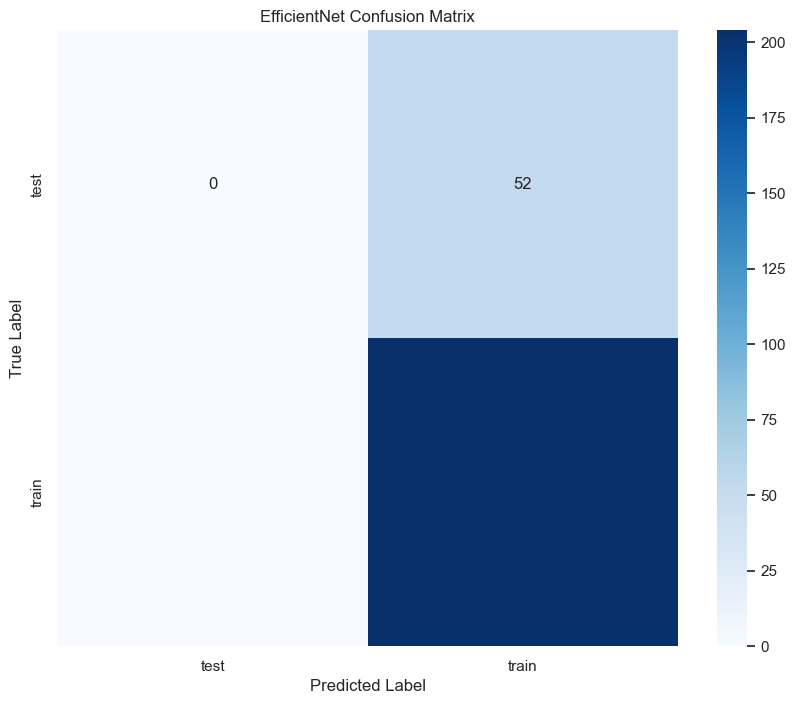

Training ViT...


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x0000028F8192BF10> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [16]:
for model_name in models_to_train:
    print(f"Training {model_name}...")
    model = create_model(model_name)
    history, accuracy, loss = compile_and_train(model, model_name)
    f1, cm = evaluate_model(model, model_name)
    
    # Store results for comparison
    results[model_name] = {
        "accuracy": accuracy,
        "loss": loss,
        "f1_score": f1,
        "confusion_matrix": cm,
        "history": history
    }

In [17]:
comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [results[m]["accuracy"] for m in results],
    "F1 Score": [results[m]["f1_score"] for m in results],
    "Loss": [results[m]["loss"] for m in results]
})

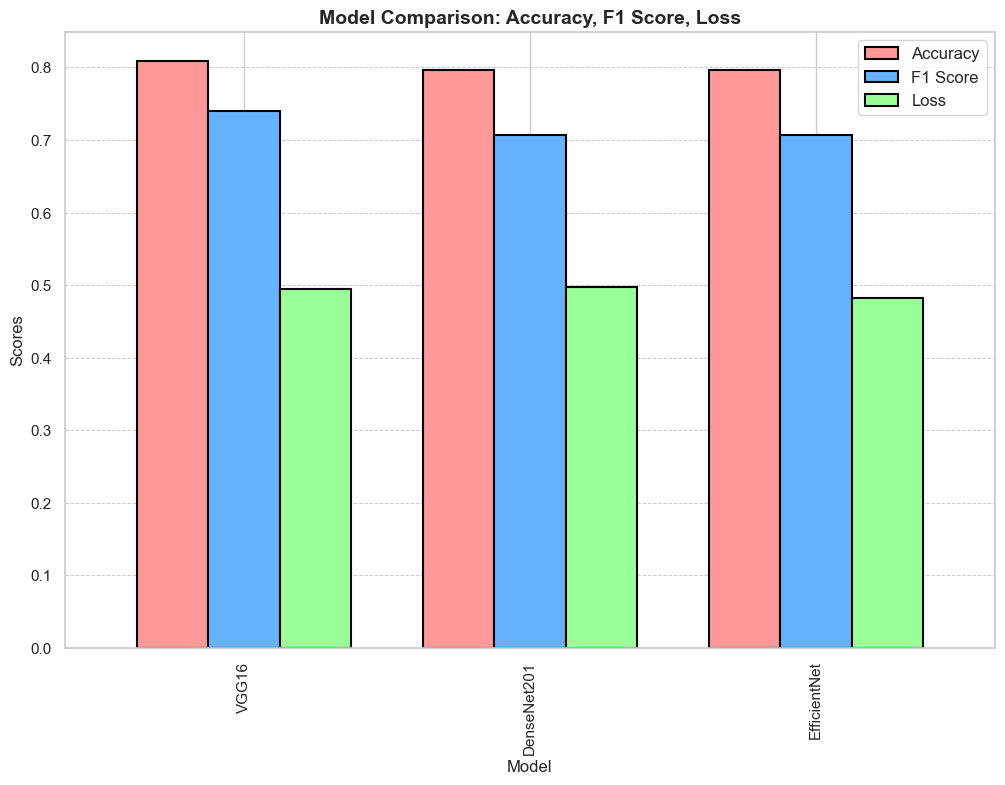

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for the plot
sns.set(style="whitegrid")  # Options: darkgrid, whitegrid, dark, white, ticks

# Define a custom color palette for the bars
custom_colors = ["#FF9999", "#66B2FF", "#99FF99"]

# Plot the comparison bar chart with customized colors and design
comparison_df.plot(
    x="Model", 
    y=["Accuracy", "F1 Score", "Loss"], 
    kind="bar", 
    figsize=(12, 8), 
    color=custom_colors,  # Apply the custom color palette
    edgecolor='black',  # Add a black border to each bar
    linewidth=1.5,      # Line width for bar borders
    width=0.75          # Adjust the width of the bars
)

# Add title and labels with customized font size and design
plt.title("Model Comparison: Accuracy, F1 Score, Loss", fontsize=14, weight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Scores", fontsize=12)

# Add a legend with a larger font size for clarity
plt.legend(fontsize=12)

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# Show the customized plot
plt.show()
